In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df_f_general = pd.read_csv('dwh_csv/f_general_metrics.csv')
df_f_cases = pd.read_csv('dwh_csv/f_cases.csv')
df_risk_scores = pd.read_csv('dwh_csv/d_risk_score.csv')
df_ages = pd.read_csv("dwh_csv/d_age.csv")
df_inmates = pd.read_csv('dwh_csv/d_inmate.csv')

In [37]:
df_f_general.columns

Index(['population', 'unemployment_rate', 'participation_rate', 'poverty_nb',
       'poverty_percentage', 'prisoners_count', 'violent_crimes_total',
       'murder_manslaughter', 'robbery', 'agg_assault', 'property_crime_total',
       'burglary', 'larceny', 'vehicle_theft', 'rape', 'state_id', 'row_id',
       'date'],
      dtype='object')

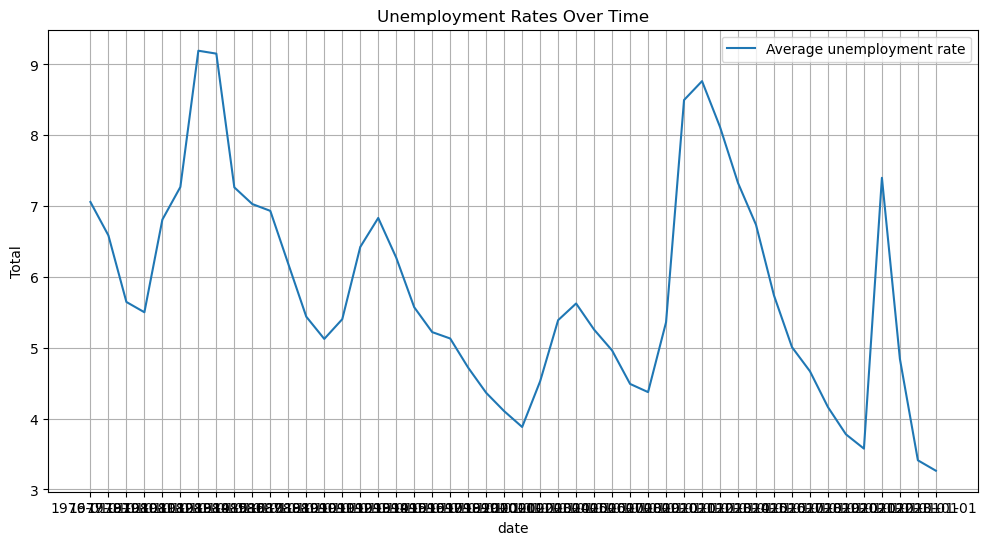

In [43]:
df_general_grouped = df_f_general.groupby(['date']).agg({
    'violent_crimes_total': 'sum',
    'property_crime_total': 'sum',
    'prisoners_count': 'sum',
    'unemployment_rate': 'mean',
    'poverty_percentage': 'mean',
    'participation_rate' : 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_general_grouped['date'], df_general_grouped['unemployment_rate'], label='Average unemployment rate')
plt.xlabel('date')
plt.ylabel('Total')
plt.title('Unemployment Rates Over Time')
plt.legend()
plt.grid(True)
plt.show()

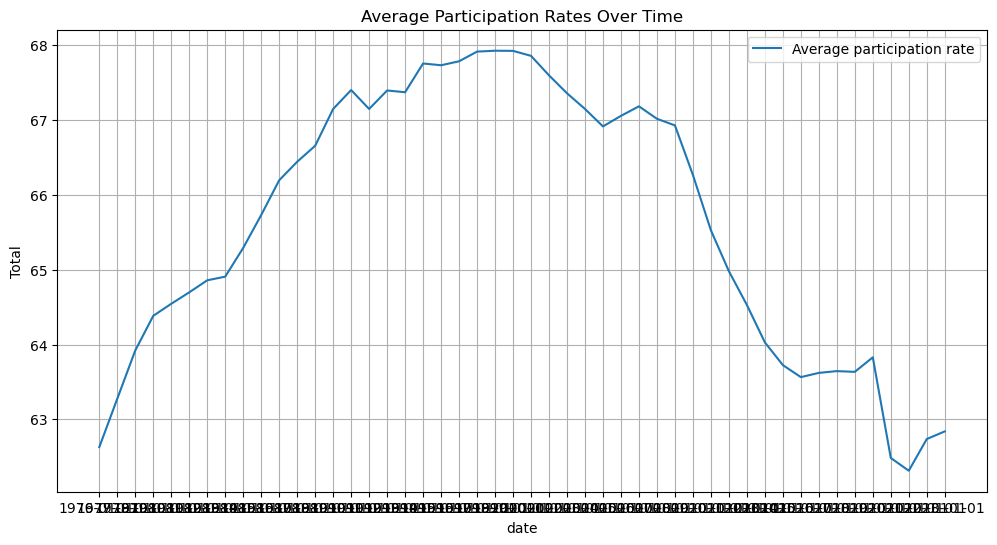

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(df_general_grouped['date'], df_general_grouped['participation_rate'], label='Average participation rate')
plt.xlabel('date')
plt.ylabel('Total')
plt.title('Average Participation Rates Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
print(df_general_grouped.columns)

Index(['date', 'violent_crimes_total', 'property_crime_total',
       'prisoners_count', 'unemployment_rate', 'poverty_percentage',
       'participation_rate'],
      dtype='object')


22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:01:55 - cmdstanpy - INFO - Chain [1] done processing
22:01:55 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing


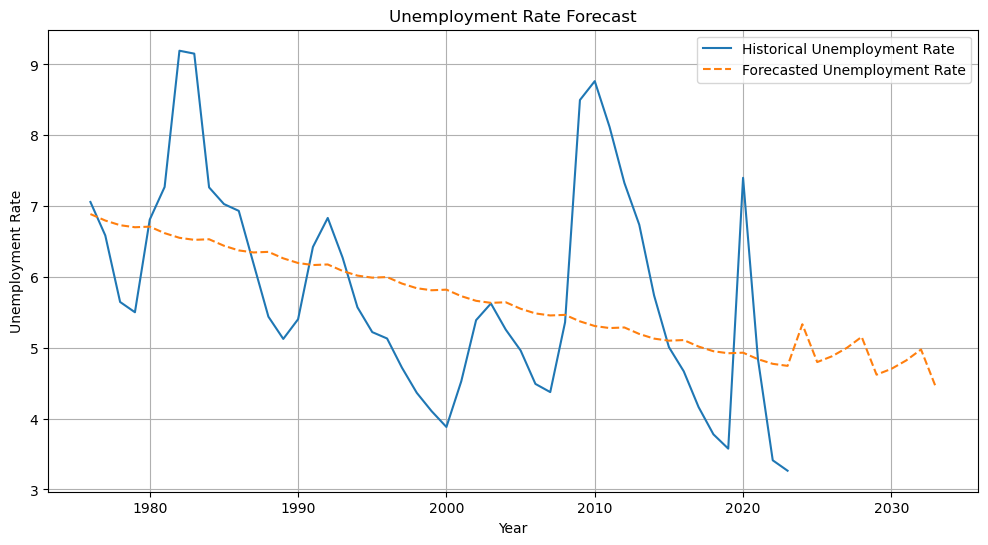

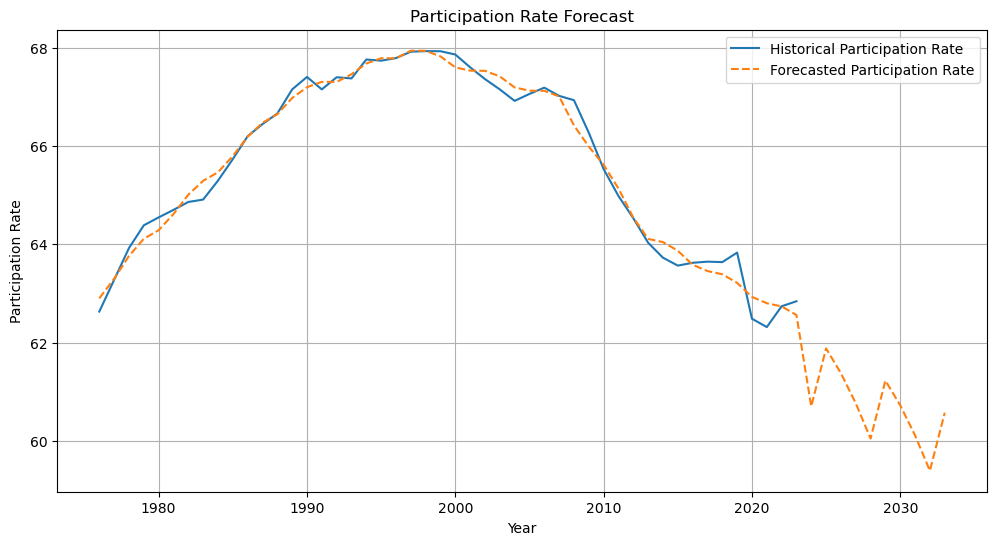

In [51]:
from prophet import Prophet
df_general_grouped['date'] = pd.to_datetime(df_general_grouped['date'])
df_general_grouped.reset_index(drop=True, inplace=True)


df_unemployment = df_general_grouped[['date', 'unemployment_rate']].rename(columns={'date': 'ds', 'unemployment_rate': 'y'})
df_participation = df_general_grouped[['date', 'participation_rate']].rename(columns={'date': 'ds', 'participation_rate': 'y'})

df_unemployment = df_unemployment.dropna()
df_participation = df_participation.dropna()

model_unemployment_prophet = Prophet()
model_unemployment_prophet.fit(df_unemployment)
future_unemployment = model_unemployment_prophet.make_future_dataframe(periods=10, freq='Y')
forecast_unemployment_prophet = model_unemployment_prophet.predict(future_unemployment)

# Fit Prophet model for Participation Rate
model_participation_prophet = Prophet()
model_participation_prophet.fit(df_participation)
future_participation = model_participation_prophet.make_future_dataframe(periods=10, freq='Y')
forecast_participation_prophet = model_participation_prophet.predict(future_participation)

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_unemployment['ds'], df_unemployment['y'], label='Historical Unemployment Rate')
plt.plot(forecast_unemployment_prophet['ds'], forecast_unemployment_prophet['yhat'], label='Forecasted Unemployment Rate', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Forecast')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_participation['ds'], df_participation['y'], label='Historical Participation Rate')
plt.plot(forecast_participation_prophet['ds'], forecast_participation_prophet['yhat'], label='Forecasted Participation Rate', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Participation Rate')
plt.title('Participation Rate Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
df_f_general['date'] = pd.to_datetime(df_f_general['date'])

df_filtered = df_f_general[(df_f_general['date'].dt.year >= 2011) & (df_f_general['date'].dt.year <= 2021)]

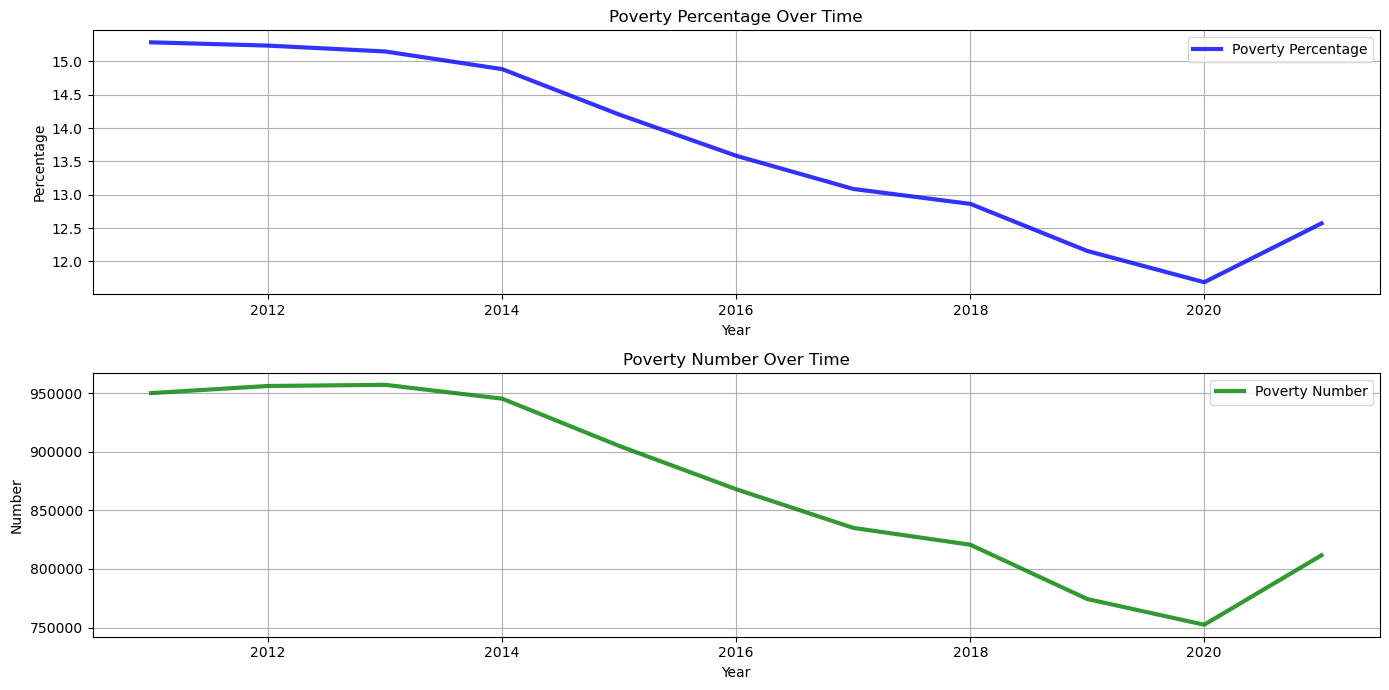

In [59]:

df_yearly = df_filtered.groupby('date').agg({
    'poverty_percentage': 'mean',
    'poverty_nb': 'mean'
}).reset_index()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df_yearly['date'], df_yearly['poverty_percentage'], label='Poverty Percentage', color='blue', alpha=0.8, linewidth=3)
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Poverty Percentage Over Time')
plt.legend()
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_yearly['date'], df_yearly['poverty_nb'], label='Poverty Number', color='green', alpha=0.8, linewidth=3)
plt.xlabel('Year')
plt.ylabel('Number')
plt.title('Poverty Number Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


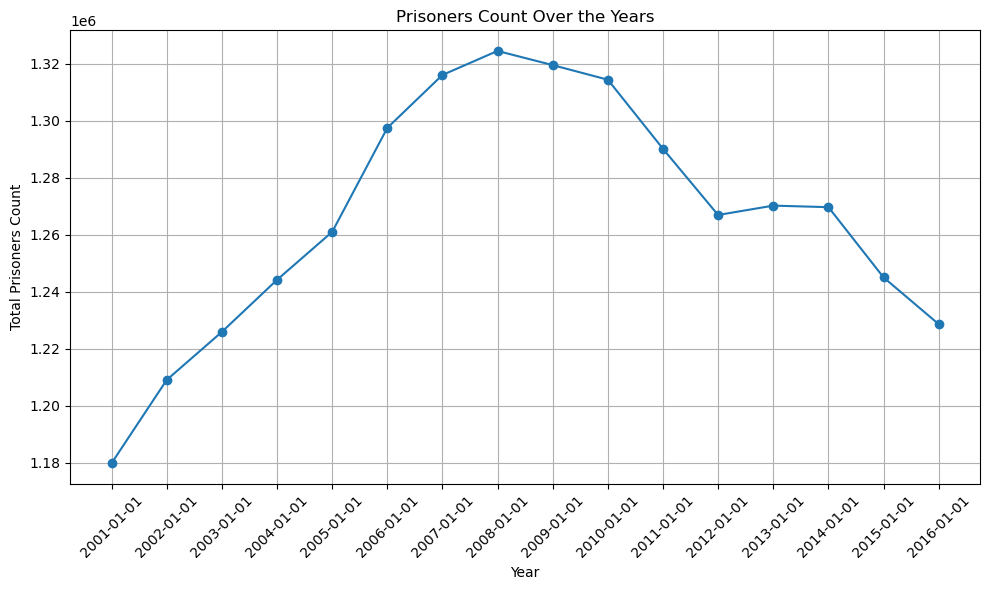

In [69]:
filtered_df = df_f_general[(df_f_general['date'].dt.year >= 2001) & (df_f_general['date'].dt.year <= 2016)]
yearly_summary = filtered_df.groupby('date')['prisoners_count'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_summary['date'], yearly_summary['prisoners_count'], marker='o')
plt.xlabel('Year')
plt.ylabel('Total Prisoners Count')
plt.title('Prisoners Count Over the Years')
plt.grid(True)
plt.xticks(yearly_summary['date'], rotation=45)
plt.tight_layout()
plt.show()

In [111]:
df_f_general.columns = df_f_general.columns.str.strip()


C:\Users\user\AppData\Local\Temp\ipykernel_1820\1375976246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'poverty_per_capita'] = df_filtered['poverty_nb'] / df_filtered['population']


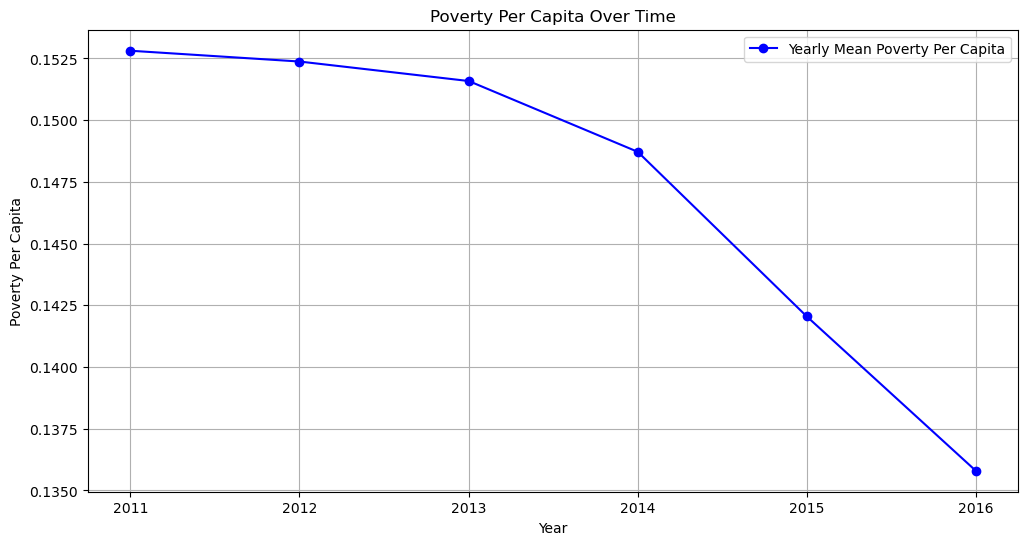

In [115]:

df_filtered.loc[:, 'poverty_per_capita'] = df_filtered['poverty_nb'] / df_filtered['population']
df_yearly_mean = df_filtered.groupby('date')['poverty_per_capita'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_mean['date'], df_yearly_mean['poverty_per_capita'], marker='o', label='Yearly Mean Poverty Per Capita', color='blue')
plt.xlabel('Year')
plt.ylabel('Poverty Per Capita')
plt.title('Poverty Per Capita Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [132]:
df_f_cases.reset_index()

,screening_date,Case_id,juvenile_felony_count,juvenile_misdemeanor_count,juvenile_other_offense_count,prior_offense_count,days_between_screening_and_arrest,days_from_compas_to_current_offense,is_recidivist,arrest_to_rec,...,charge_id,rec_charge_id,inmate_id,sentence_type_id,state_id,recidivism_risk_score_id,violence_risk_score_id,current_jail_entry_date,current_jail_release_date,recidivism_offense_date
0,2013-08-14,0,0,0,0,0,-1,1,0,0,...,1,2,1,1,11,1,1,2013-08-13,2013-08-14,NaN
1,2014-12-31,1,0,0,0,0,-1,-1,-1,0,...,2,2,2,2,11,2,9,NaN,NaN,NaN
2,2013-01-27,2,0,0,0,0,-1,1,1,0,...,3,119,3,2,11,3,1,2013-01-26,2013-05-02,2013-05-07
3,2013-04-14,3,0,0,1,4,-1,1,1,0,...,4,118,4,2,11,4,3,2013-04-13,2013-04-14,2013-06-16
4,2013-01-13,4,0,1,0,1,-1,1,0,0,...,5,2,5,2,11,5,6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11008,2014-04-11,10996,0,0,0,0,-1,1,0,0,...,630,2,10997,1,11,3,2,NaN,NaN,NaN
11009,2013-08-21,10997,0,0,0,5,-1,1,0,0,...,7,2,10998,2,11,6,4,2013-08-20,2013-08-21,NaN
11010,2013-05-11,10998,0,0,0,0,-1,1,0,0,...,98,2,10999,1,11,1,1,2013-04-11,2013-05-11,NaN
11011,2014-03-26,10999,0,0,0,3,-1,1,0,0,...,26,2,11000,1,11,9,9,2014-03-25,2014-03-26,2015-06-03


In [143]:
df_f_cases.set_index('current_jail_entry_date', inplace=True)


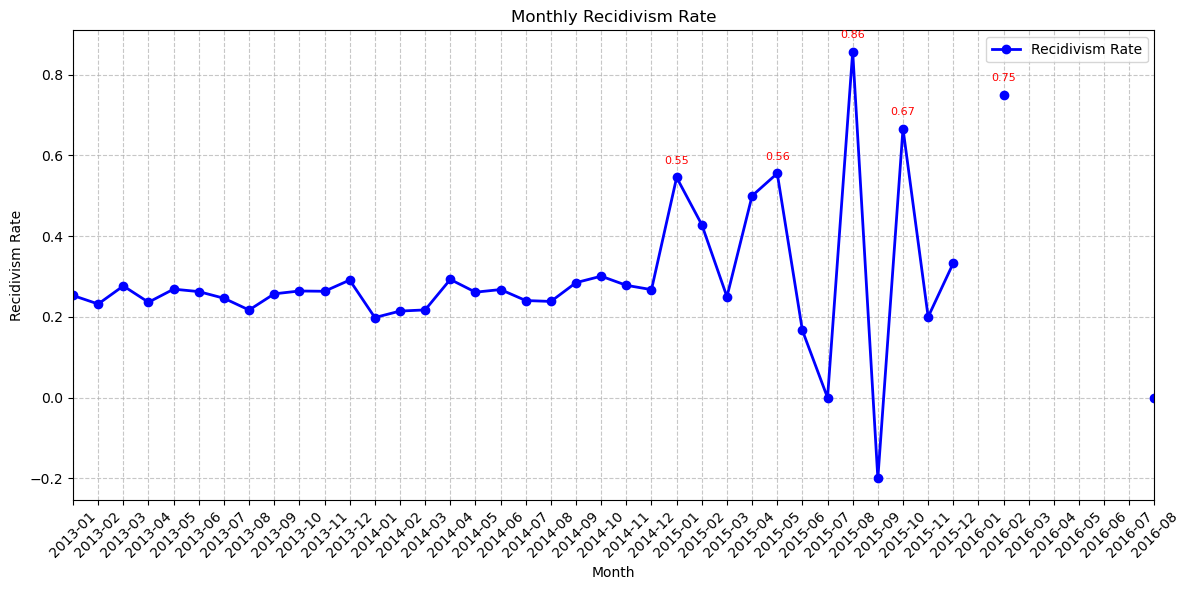

In [157]:
yearly_recidivism_rate = df_f_cases['is_recidivist'].resample('M').mean()

plt.figure(figsize=(12, 6))
ax = yearly_recidivism_rate.plot(kind='line', marker='o', linestyle='-', color='b', title='Monthly Recidivism Rate', linewidth=2, markersize=6)

ax.set_xlabel('Month')
ax.set_ylabel('Recidivism Rate')
ax.legend(['Recidivism Rate'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(yearly_recidivism_rate.index, yearly_recidivism_rate.index.strftime('%Y-%m'), rotation=45)
plt.tight_layout()


for i, rate in enumerate(yearly_recidivism_rate):
    if rate > 0.5: 
        ax.annotate(f'{rate:.2f}', (yearly_recidivism_rate.index[i], rate), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.show()

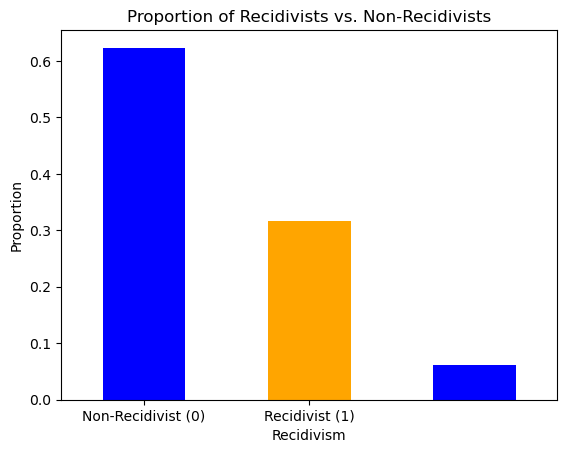

In [163]:
proportions = df_f_cases['is_recidivist'].value_counts(normalize=True)

# Plot
proportions.plot(kind='bar', color=['blue', 'orange'])
plt.title('Proportion of Recidivists vs. Non-Recidivists')
plt.xlabel('Recidivism')
plt.ylabel('Proportion')
plt.xticks(ticks=[0, 1], labels=['Non-Recidivist (0)', 'Recidivist (1)'], rotation=0)
plt.show()

<Axes: title={'center': 'Count of Recidivism vs Non-Recidivism'}, xlabel='is_recidivist'>

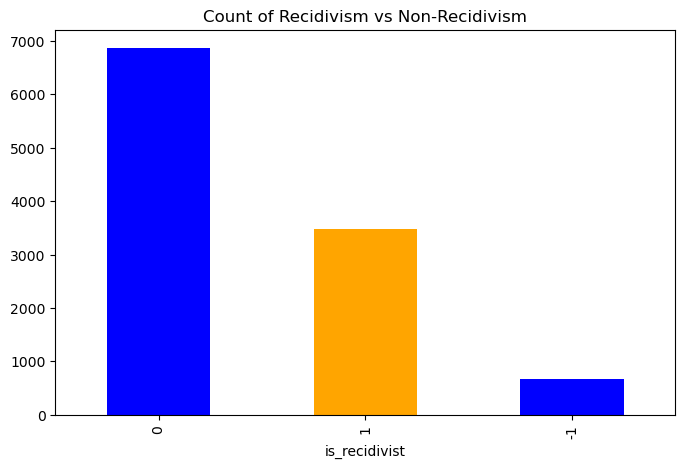

In [10]:
recidivism_counts = df_f_cases['is_recidivist'].value_counts()
recidivism_counts.plot(kind='bar', title='Count of Recidivism vs Non-Recidivism', figsize=(8, 5), color=['blue', 'orange'])
